In [3]:
import os
from minimal.solver import Solver
from minimal import armatures
from minimal.models import KinematicModel, KinematicPCAWrapper
import numpy as np
import minimal.config as config
from dataloader.result_loader import KinectResultLoader
from minimal.bridge import JointsBridge
import torch
from pytorch3d.structures import Pointclouds

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

from dataloader.utils import ymdhms_time

%load_ext autoreload
%autoreload 2

np.random.seed(20160923)

In [4]:
n_pose = 23 * 3 # degrees of freedom, (n_joints - 1) * 3
# smpl 1.0.0: 10
# smpl 1.1.0: 300
n_shape = 10

k_loader = KinectResultLoader('/media/nesc525/perple/2021-08-18_10-49-44-T')
files = k_loader.select_item(298, "id")
kinect_skeleton = np.load(files["kinect/master/skeleton"]["filepath"])
kinect_pcls = np.vstack(np.load(files['kinect/master/pcls']["filepath"]))

bridge = JointsBridge()
kpts_gt, pcl_gt, origin_scale = bridge.smpl_from_kinect(kinect_skeleton[0], kinect_pcls)


mesh = KinematicModel(config.SMPL_MODEL_1_0_MALE_PATH, armatures.SMPLArmature, scale=1)

wrapper = KinematicPCAWrapper(mesh, n_pose=n_pose)
solver = Solver(wrapper, max_iter=int(10e7))

mesh_init, kpts_init = wrapper.run(np.zeros(wrapper.n_params))

Loading .png from /media/nesc525/perple/2021-08-18_10-49-44-T/kinect/master/color
Loading .png from /media/nesc525/perple/2021-08-18_10-49-44-T/kinect/master/depth
Loading .npy from /media/nesc525/perple/2021-08-18_10-49-44-T/kinect/master/pcls
Loading .npy from /media/nesc525/perple/2021-08-18_10-49-44-T/kinect/master/skeleton


In [10]:
from visualization.pcd_visual import plot_minimal_input

plot_minimal_input(kpts_gt, kpts_init, pcl_gt, mesh_init)

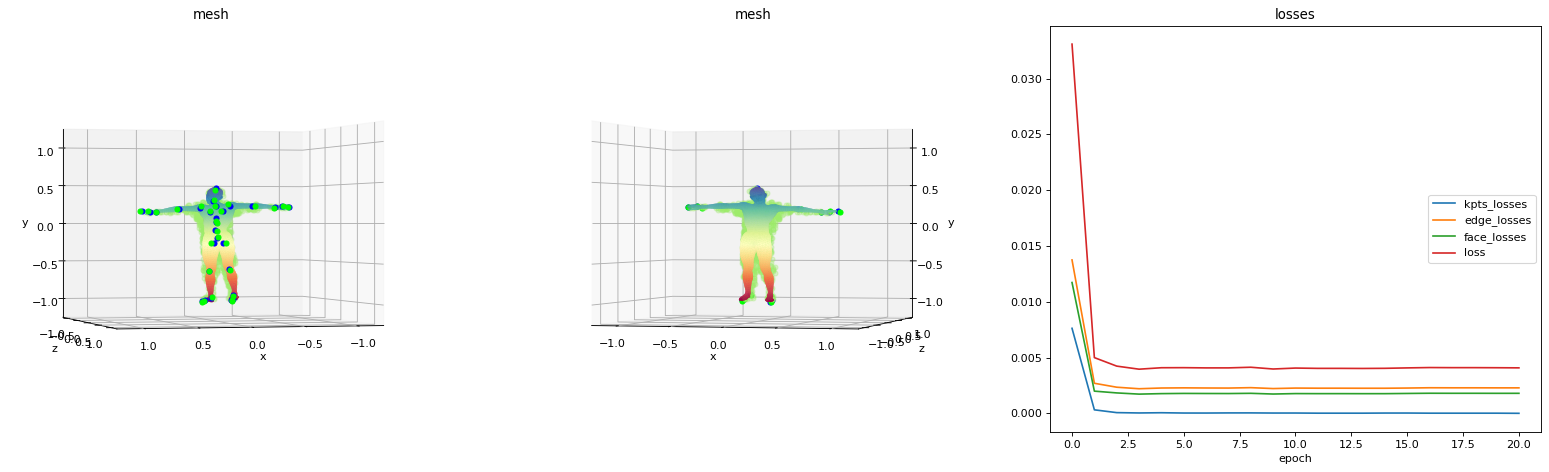

losses
	kpts_losses      	 (min:    0.000, max:    0.008, cur:    0.000)
	edge_losses      	 (min:    0.002, max:    0.014, cur:    0.002)
	face_losses      	 (min:    0.002, max:    0.012, cur:    0.002)
	loss             	 (min:    0.004, max:    0.033, cur:    0.004)


In [167]:
params_est = solver.solve_full(kpts_gt, pcl_gt, origin_scale, verbose=1)

In [168]:
shape_est, pose_pca_est, pose_glb_est = wrapper.decode(params_est)

print('----------------------------------------------------------------------')
print('estimated parameters')
print('pose pca coefficients:', pose_pca_est)
print('pose global rotation:', pose_glb_est)
print('shape: pca coefficients:', shape_est)

mesh.set_params(pose_pca=pose_pca_est)
mesh.save_obj(os.path.join(config.SAVE_PATH, './esttm={}.obj'.format(ymdhms_time())))

----------------------------------------------------------------------
estimated parameters
pose pca coefficients: [ 3.53877444e-02 -3.72527256e-02  1.83216445e-01  4.25896097e-02
 -7.75828793e-02  1.26419593e-01  2.61529887e-02 -1.39049392e-01
  2.91511962e-01  1.02989575e-01 -5.76885178e-02  1.92448317e-02
  1.58246169e-01  2.75083403e-02 -3.67880839e-02 -5.09457401e-01
  5.56446972e-02 -1.11022954e-01 -3.27461841e-01  1.66645860e-02
 -5.79711552e-02 -1.60538697e-01 -3.27888811e-02 -1.03825908e-02
  3.57783041e-01  6.74097520e-02 -9.83137097e-02  4.14026391e-01
  8.00971808e-01  1.52069848e-01  3.14104847e-01 -2.87080483e-01
 -4.15098249e-02  3.69967390e-01  1.70460487e-01  3.35873440e-02
  3.13925713e-01 -1.28537865e-04  2.86599219e-01  3.40664151e-01
  4.89382563e-02 -2.76575183e-01 -8.66255104e-02  6.44034731e-02
  2.77641532e-01  5.56837702e-02  4.43666027e-02 -2.80127197e-01
  8.31385886e-02  2.65906720e-03  4.09151140e-01  3.37693601e-02
 -1.11557851e-01 -5.85772917e-02  7.3116